# Project Name: Custom Implementation of t-SNE: Educational Exploration and Comparison with Existing Libraries

**Overview:**
This project guides students through developing their own implementation of the t-Distributed Stochastic Neighbor Embedding (t-SNE) algorithm, a powerful dimensionality reduction technique widely used for visualizing high-dimensional data. Students will gain in-depth knowledge of t-SNE by comparing their custom implementation to existing standard libraries.

**You have:**
* High-dimensional dataset -- Iris dataset which is suitable for visualization.
* Fundamental Python programming skills and familiarity with libraries such as NumPy and matplotlib.

**We will:**
1. Develop a step-by-step custom implementation of the t-SNE algorithm, covering core concepts such as pairwise similarity calculation, probability distributions, and gradient descent optimization.
2. Compare and validate the results of our custom implementation with popular existing implementations, such as scikit-learn's t-SNE, analyzing differences and performance metrics.
3. Visualize and interpret the embeddings produced by both the custom and existing implementations, highlighting key insights and discussing practical implications.

**Goal:**
Students will achieve a thorough understanding of t-SNE's mathematical foundation, practical implementation details, and performance considerations, empowering them to adapt or extend this technique for diverse data visualization challenges.

In [10]:
import numpy as np                  
import matplotlib.pyplot as plt     
from sklearn import datasets       
from sklearn.decomposition import PCA  
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

In [2]:
iris = datasets.load_iris()
X = iris.data       
y = iris.target     


pca = PCA(n_components=4)           
X_pca = pca.fit_transform(X)

### What is t-SNE?
t-SNE (t-Distributed Stochastic Neighbor Embedding) is a powerful dimensionality reduction technique specifically designed for visualizing high-dimensional data. Developed by Laurens van der Maaten and Geoffrey Hinton in 2008, it's particularly effective at preserving local structures in the data while revealing global patterns like clusters.

### Core Concepts of t-SNE
* Similarity Representation
t-SNE works by converting high-dimensional Euclidean distances between points into conditional probabilities that represent similarities:

* High-dimensional similarities (P): Uses a Gaussian distribution where similar points have high probability of being selected as neighbors

* Low-dimensional similarities (Q): Uses a Student's t-distribution (heavier tails) to avoid the "crowding problem"

In [3]:
# Helper: Compute pairwise squared Euclidean distances
# Computes the squared Euclidean distance matrix for dataset X
# Input: X (n_samples x n_features)
# Output: D (n_samples x n_samples) distance matrix
def pairwise_distances(X):
    sum_X = np.sum(np.square(X), axis=1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    return D

## Helper: Compute entropy and conditional probability for a given beta (precision)
##
## This function:
## Computes conditional probabilities using Gaussian kernel with precision parameter beta
## Calculates the Shannon entropy of the resulting distribution
## Includes safeguards against numerical instabilities
## 
def Hbeta(Di, beta, eps=1e-12):
    P = np.exp(-Di * beta)
    sumP = np.sum(P)
    if sumP < eps:
        H = 0
        P = np.zeros_like(P)
    else:
        H = np.log(sumP) + beta * np.sum(Di * P) / sumP
        P = P / sumP
    return H, P

## Compute high-dimensional affinities P using binary search to match target perplexity
## Input: D distance matrix, perplexity target
## Output: P matrix of conditional probabilities
##
## This function:
## Performs binary search to find the precision (beta) for each point that gives the target perplexity
## Dynamically adjusts beta until the entropy matches the log of perplexity
## Handles edge cases like numerical instability
##
def compute_perplexity(D, tol=1e-5, perplexity=30.0):
    n, _ = D.shape
    P = np.zeros((n, n))
    logU = np.log(perplexity)

    for i in range(n):
        betamin = -np.inf
        betamax =  np.inf
        beta    = 1.0

        # leave out the i-th point
        Di = D[i, np.r_[0:i, i+1:n]]

        # initial entropy + P
        H, thisP = Hbeta(Di, beta)
        Hdiff    = H - logU
        tries    = 0

        while np.abs(Hdiff) > tol and tries < 50:
            if Hdiff > 0:
                # entropy too high → increase precision
                betamin = beta
                if np.isposinf(betamax):
                    beta = beta * 2.0
                else:
                    beta = (beta + betamax) / 2.0
            else:
                # entropy too low → decrease precision
                betamax = beta
                if np.isneginf(betamin):
                    beta = beta / 2.0
                else:
                    beta = (beta + betamin) / 2.0

            H, thisP = Hbeta(Di, beta)
            Hdiff    = H - logU
            tries   += 1

        P[i, np.r_[0:i, i+1:n]] = thisP

    return P

## Symmetrize P and normalize
## Ensures P is symmetric and normalized to sum to 1
##
## This function:
## Converts conditional probabilities to joint probabilities
## Makes the distribution symmetric
## Ensures minimum probability values for numerical stability
##
def compute_joint_probabilities(P):
    P = (P + P.T) / (2 * P.shape[0])  # Fixed: P.shape -> P.shape[0]
    P = np.maximum(P, 1e-12)
    return P

## Initialize low-dimensional map Y randomly
## Input: number of points n, output dimension dim
## Output: initialized embedding Y
##
## This function creates the initial low-dimensional representation with small random values.
def initialize_Y(n, dim=2):
    return np.random.randn(n, dim) * 1e-4

## Compute low-dimensional affinities Q using Student t-distribution
## Includes numerical stability fixes
##
## This function:
## Computes the pairwise distances in the low-dimensional space
## Transforms these distances using a Student's t-distribution (1/(1+d²))
## Normalizes to create a proper probability distribution Q
## Returns both Q and the unnormalized affinities (needed for gradient calculation)
##
def compute_low_dim_affinities(Y, eps=1e-12):
    sum_Y = np.sum(np.square(Y), axis=1)
    num = 1 / (1 + np.add(np.add(-2 * np.dot(Y, Y.T), sum_Y).T, sum_Y))
    np.fill_diagonal(num, 0)
    Q = num / np.maximum(np.sum(num), eps)
    Q = np.maximum(Q, eps)
    return Q, num

## Compute gradient of Kullback-Leibler divergence
## Includes numerical stability fixes
##
## This function:
## Computes the gradient of the KL divergence with respect to Y
## The PQ difference determines whether points are pushed apart or pulled together
## Scaled by the t-distribution factor and the difference in coordinates
def compute_gradient(P, Q, num, Y, eps=1e-12):
    PQ_diff = np.maximum(P - Q, -1 + eps)
    n, dim = Y.shape
    dY = np.zeros((n, dim))
    for i in range(n):
        dY[i, :] = np.sum(np.tile(PQ_diff[:, i] * num[:, i], (dim, 1)).T * (Y[i, :] - Y), 0)
    return 4 * dY

## Safer cost calculation with small epsilon to prevent log(0)
##
## This function:
## Computes the Kullback-Leibler divergence between P and Q
## Includes safety measures for numerical stability
## Lower values indicate better embedding
##
def calculate_cost(P, Q, eps=1e-12):
    P_safe = np.maximum(P, eps)
    Q_safe = np.maximum(Q, eps)
    C = np.sum(P_safe * np.log(P_safe / Q_safe))
    return C

In [4]:
# Main t-SNE function
# Parameters: perplexity, number of iterations, learning rate, momentum
# Includes early exaggeration and fixes for numerical stability
def tsne(X, perplexity=30.0, n_iter=500, learning_rate=200.0, momentum=0.5):
    n, dim = X.shape

    # Phase 1: Initialization
    print("Computing pairwise distances...")
    D = pairwise_distances(X)

    print("Computing conditional probabilities P...")
    P = compute_perplexity(D, perplexity=perplexity)
    P = compute_joint_probabilities(P)
    P = P * 4  # Early exaggeration
    # Early exaggeration (multiplying P by 4 initially) helps to create more space 
    # between natural clusters early in the optimization. This is removed after 
    # 100 iterations to allow fine-tuning of the embedding.
    
    Y = initialize_Y(n)
    iY = np.zeros_like(Y) # Momentum accumulator
    # Momentum helps accelerate gradients in the right direction and dampens oscillations

    # Phase 2: Gradient descent optimization
    print("Starting gradient descent optimization...")
    for iter in range(n_iter):
        # Compute Q and gradient
        Q, num = compute_low_dim_affinities(Y)
        grad = compute_gradient(P, Q, num, Y)
        
        # Update Y with momentum and adaptive learning rate
        current_lr = learning_rate * (1.0 - iter / float(n_iter))
        iY = momentum * iY - current_lr * grad
        Y = Y + iY # Position update

        # Remove early exaggeration
        if iter == 100:
            P = P / 4  # End early exaggeration
        
        # Print progress
        if iter % 100 == 0:
            C = calculate_cost(P, Q)
            print(f"Iteration {iter}: error = {C:.4f}")
    return Y

In [5]:
# Run custom t-SNE
Y_custom = tsne(X_pca, perplexity=30.0, n_iter=500, learning_rate=200.0)

Computing pairwise distances...
Computing conditional probabilities P...
Starting gradient descent optimization...
Iteration 0: error = 11.6597
Iteration 100: error = 0.9638
Iteration 200: error = 0.1433
Iteration 300: error = 0.1407
Iteration 400: error = 0.1395


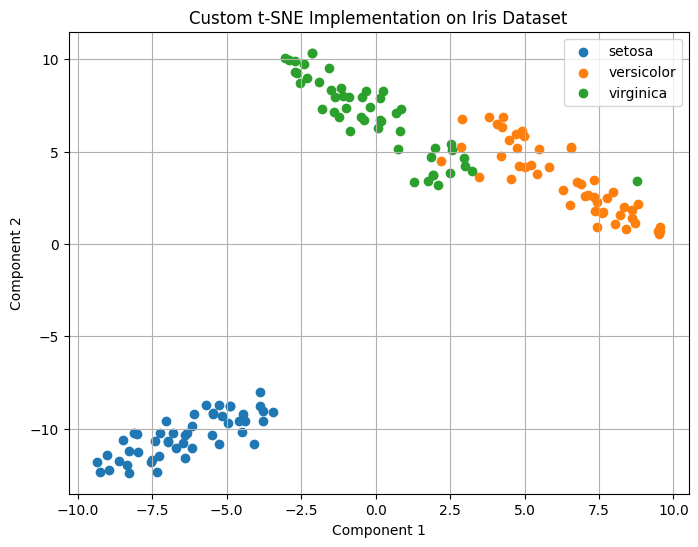

In [6]:
plt.figure(figsize=(8, 6))
for label in np.unique(y):
    plt.scatter(Y_custom[y == label, 0], Y_custom[y == label, 1], label=iris.target_names[label])
plt.title('Custom t-SNE Implementation on Iris Dataset')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Run scikit-learn t-SNE for comparison
tsne_sklearn = TSNE(n_components=2, perplexity=30, n_iter=500, learning_rate=200, random_state=42)
Y_sklearn = tsne_sklearn.fit_transform(X_pca)

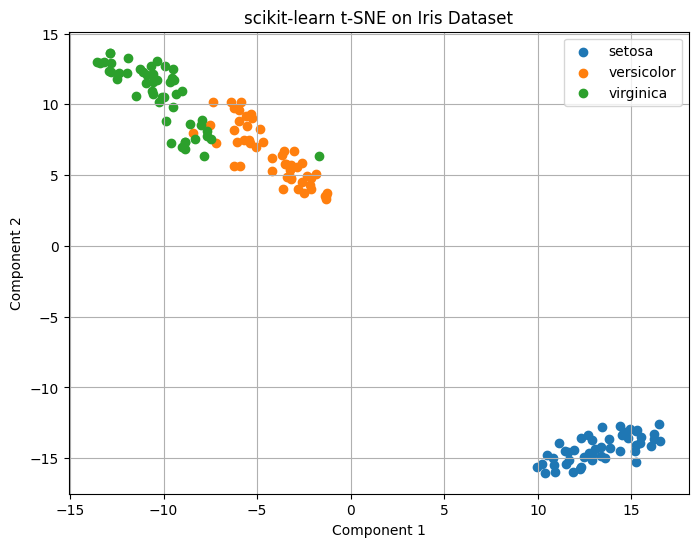

In [12]:
# Plot scikit-learn t-SNE results
plt.figure(figsize=(8, 6))
for label in np.unique(y):
    plt.scatter(Y_sklearn[y == label, 0], Y_sklearn[y == label, 1], label=iris.target_names[label])
plt.title('scikit-learn t-SNE on Iris Dataset')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.grid(True)
plt.show()